In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

In [3]:
model_path = '../model/' + scenario + '/'
input_path = '../input/'
output_path = '../output/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

# OD matrix generation non-compulsory

## Needs trip generation and destination choice model results

## Saves volumes table for non-compulsory trips

In [5]:
# Transport demand segments
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes_compulsory = ['commuting', 'business', 'education']
purposes_optional = ['buy/execute', 'leisure', 'accompany']
segments_compulsory = [s for s in segments if s.split('_')[0] in purposes_compulsory]
segments_optional = [s for s in segments if s.split('_')[0] in purposes_optional]

In [6]:
# Load zones
sm = stepmodel.read_json(model_path + 'de_zones')

## Destination choice

### Create zone attributes table

Use number of POIs from OSM and generalised composite cost from mode choice for a "Level-of-Service" table for different zones

In [7]:
# Create OD stack for all zones accounted in OD set (or CC, if OD set not computed)
try:
    od_set = json.load(open(model_path + 'od_set.json'))
    od_set = [tuple(l) for l in od_set]
    origin_set = [l[0] for l in od_set]
    destination_set = [l[1] for l in od_set]
except FileNotFoundError:
    od_set = None
    origin_set = set(cc_inter.index.get_level_values(0))
    destination_set = set(cc_inter.index.get_level_values(1))
sm.los = sm.zones.loc[sm.zones['FID'].isin(origin_set), ['FID', 'urbanisation']].merge(
    sm.zones.loc[sm.zones['FID'].isin(destination_set),
                 ['FID', 'urbanisation', 'population', 'area', 'employment']
                ], how='cross', suffixes=('_o', '_d'))
sm.los.rename(columns={'FID_o':'origin', 'FID_d':'destination',
                       'population':'population_d', 'area': 'area_d',
                       'employment': 'employment_d'}, inplace=True)
if od_set:
    sm.los = sm.los.set_index(['origin', 'destination']).loc[od_set].reset_index()
# Drop inner-zonal
sm.los = sm.los.loc[sm.los['origin']!=sm.los['destination']]
assert sm.los.isna().any(axis=1).max() == 0
len(sm.los)

263004

In [8]:
# Assign OD distances
distances = skims.euclidean(sm.zones, coordinates_unit=sm.coordinates_unit, intrazonal=False)
sm.los['distance'] = sm.los.set_index(['origin', 'destination']).index.map(
    distances.set_index(['origin', 'destination'])['euclidean_distance']/1000).fillna(1e3)

In [9]:
# Load POI values
pois = pd.read_csv(input_path + 'spatial_num_pois_raw.csv', index_col='index')
cats = pd.read_excel(input_path + 'spatial_OSM_POI_list.xlsx', sheet_name='categories')
cats['label'] = (cats['key'] + ' ' + cats['value'].fillna('')).str.strip()
for category, columns in cats.loc[cats['category'].notna()
                                 ].groupby('category').agg(
                                {'label': list})['label'].items():
    sm.los[category] = sm.los['destination'].map(pois[columns].sum(axis=1)) \
                       * sm.los['urbanisation_d'].map(params['poi_change']).astype(float) + 1

In [10]:
# Add one, so that it is 0 nowhere
sm.los['employment_d'] += 1
sm.los['population_d'] += 1
sm.los['area_d'] += 1

In [11]:
# Load inter-zonal composite cost from mode choice step
try:
    cc = pd.read_csv(output_path + scenario + '/mode_choice_od_composite_cost.csv')
except FileNotFoundError:
    try:
        cc = pd.read_csv(output_path + 'base' + '/mode_choice_od_composite_cost.csv')
    except FileNotFoundError:
        raise FileNotFoundError(
            'You can compute composite cost with the mode choice model or download them in the latest major release')
cc.set_index(['origin', 'destination'], inplace=True)

In [12]:
# Add CC
sm.los = sm.los.set_index(['origin', 'destination']).merge(
    cc[segments_optional], how='left', left_index=True, right_index=True
).rename(columns={seg: 'cc_'+seg for seg in segments_optional}).reset_index()

In [13]:
# Fill CC NaN with average values for that segment and distance
for col in ['cc_'+seg for seg in segments_optional]:
    mask = sm.los[col].notna()
    model = LinearRegression()
    model.fit(sm.los.loc[mask, ['distance']], sm.los.loc[mask, col])
    sm.los.loc[~mask, col] = model.predict(sm.los.loc[~mask, ['distance']])

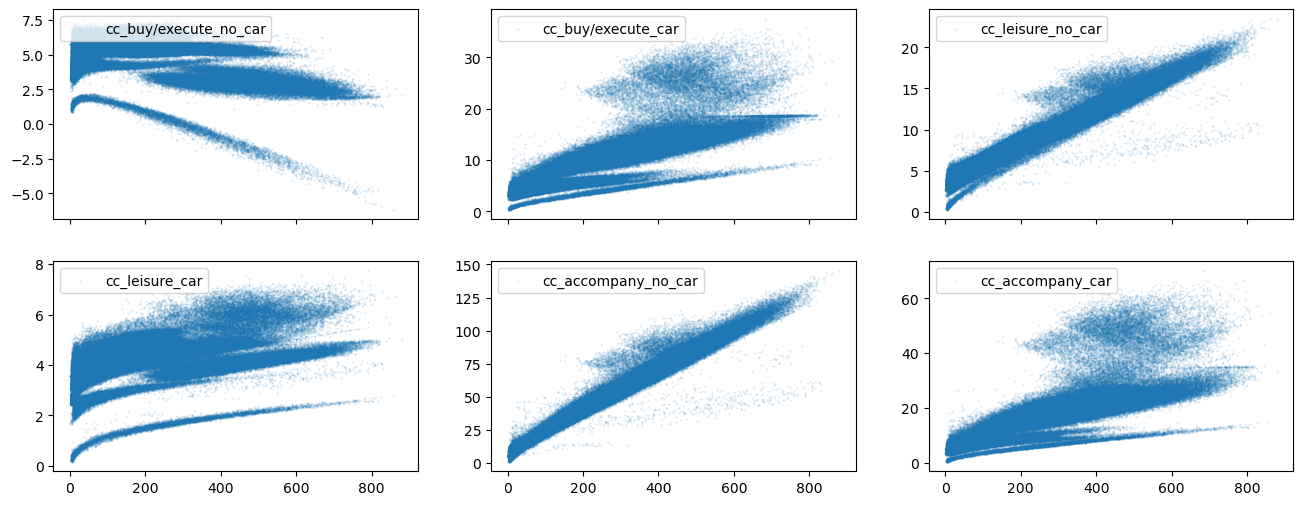

In [14]:
# visualise the the composite cost frequency (histograms)
if manual:
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(ncols=int(len(segments_optional)/2), nrows=2, sharex='all', sharey=False, figsize=(16,6))
    for ax, col in zip(axs.flat, ['cc_'+s for s in segments_optional]):
        ax.scatter(x=sm.los['distance'], y=sm.los[col], alpha=.1, s=.5, label=col)
        ax.legend(loc='upper left')
    print('')

In [15]:
# 'route type', which denotes the mode, corresponds to the column of choice
sm.los['route_type'] = sm.los['destination'].copy()
sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
# The choice (route_type) will be evaluated for every OD pair
sm.los['destination'] = 'DUMMY'

In [16]:
sm.los = sm.los.loc[sm.los.notna().all(axis=1)]
print('Number of OD pairs: {}'.format(len(sm.los)))

Number of OD pairs: 263004


### Define choice model

In [17]:
# decide whether to run nested logit model or multinomial logit model
nested = False # Nested Logit model with urbanisation degrees
daly1982 = True # Utility function not linear-in-the-parameters as in Daly (1982)

# Load estimation results, choose right file for variation!
try:
    excel_file = pd.ExcelFile(input_path + 'estimation_results_dest_inter_{}.xlsx'.format(scenario))
except FileNotFoundError:
    excel_file = pd.ExcelFile(input_path + 'estimation_results_dest_inter.xlsx')
p_dict = dict(zip(purposes_optional, [4,6,7]))
car_name = ['_no_car', '_car']
params_est = {p+car_name[c]: excel_file.parse(str(p_dict[p])+'_'+str(c)).set_index('Unnamed: 0')
              for p in purposes_optional for c in [0,1]}

In [18]:
# set the nested structure for each segment, must be the same as in the estimation
destinations = list(sm.los['route_type'].unique())
segs = segments_optional + ['root']
if nested:
    urban_dict = sm.zones['urbanisation'].to_dict()
    col = ['urban'+str(urban_dict[d]) for d in destinations] + ['root']*3 + [np.nan]
    index = destinations + ['urban1', 'urban2', 'urban3', 'root']
else: 
    col = ['root']*len(destinations) + [np.nan]
    index = destinations + ['root']
nests = pd.DataFrame(index=index, data={s: col for s in segments_optional})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests

In [19]:
# phi/theta values for each choice option and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=destinations, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for seg in segments]
# For the nested structure
if nested: 
    sm.logit_scales.loc['urban1'] = [1 / params_est[s].loc['mu_u1', 'Value'] for s in segments]
    sm.logit_scales.loc['urban2'] = [1 / params_est[s].loc['mu_u2', 'Value'] for s in segments]
    sm.logit_scales.loc['urban3'] = [1 / params_est[s].loc['mu_u3', 'Value'] for s in segments]
sm.logit_scales.columns.name = 'segment'
sm.logit_scales.index.name = 'route_type'

In [20]:
# As there are no alternative specific costants in the utility formulation, 
# the initial values are set to 0
sm.mode_utility = pd.DataFrame(index=destinations, data={seg: 0 for seg in segments})
if nested:
    sm.mode_utility.loc['urban1'] = 0
    sm.mode_utility.loc['urban2'] = 0
    sm.mode_utility.loc['urban3'] = 0
sm.mode_utility.columns.name = 'segment'
sm.mode_utility.index.name = 'route_type'

In [21]:
# Prepare attraction columns per purpose
# quetzal can only work with linear-in-the-parameters utility functions,
# but destination choice with POI values requires logarithmic formulations.
# See estimation notebook for utility formulation and scaling
for car in [0,1]:
    def get_b(p, b):
        return max(0, params_est[p+car_name[car]].loc[b, 'Value'])
    
    if daly1982:
        '''sm.los['commuting'+car_name[car]+'_attr'] = np.log(sm.los['employment_d'])
        sm.los['business'+car_name[car]+'_attr'] = np.log(sm.los['employment_d'])
        sm.los['education'+car_name[car]+'_attr'] = \
            np.log(sm.los['childcare'] * get_b('education', 'b_edu1') 
                   + sm.los['school'] * get_b('education', 'b_edu2')
                   + sm.los['higher_education'])'''
        sm.los['buy/execute'+car_name[car]+'_attr'] = \
            np.log(1 + sm.los['medical']
                   + sm.los['shop'] * get_b('buy/execute', 'b_shop1')
                   + sm.los['special_shop'] * get_b('buy/execute', 'b_shop2'))
        sm.los['leisure'+car_name[car]+'_attr'] = \
            np.log(1+ sm.los['daily_leisure']
                   + sm.los['occasional_leisure'] * get_b('leisure', 'b_leisure1')
                   + sm.los['holiday'] * get_b('leisure', 'b_leisure2'))
        sm.los['accompany'+car_name[car]+'_attr'] = \
            np.log(1 + sm.los['medical'] * get_b('accompany', 'b_accom1')
                   + sm.los['school'] * get_b('accompany', 'b_accom2')
                   + sm.los['childcare'])

    else:
        '''sm.los['commuting'+car_name[car]+'_attr'] = \
            np.log(sm.los['employment_d']) * get_b('commuting', 'b_empl')
        sm.los['business'+car_name[car]+'_attr'] = \
            np.log(sm.los['employment_d']) * get_b('business', 'b_empl')
        sm.los['education'+car_name[car]+'_attr'] = \
            np.log(sm.los['higher_education']) * get_b('education', 'b_edu1') \
            + np.log(sm.los['school']) * get_b('education', 'b_edu2') \
            + np.log(sm.los['childcare']) * get_b('education', 'b_edu3')'''
        sm.los['buy/execute'+car_name[car]+'_attr'] = \
            np.log(sm.los['medical']) * get_b('buy/execute', 'b_shop1') \
            + np.log(sm.los['shop']) * get_b('buy/execute', 'b_shop2') \
            + np.log(sm.los['special_shop']) * get_b('buy/execute', 'b_shop3')
        sm.los['leisure'+car_name[car]+'_attr'] = \
            np.log(sm.los['holiday']) * get_b('leisure', 'b_leisure1') \
            + np.log(sm.los['daily_leisure']) * get_b('leisure', 'b_leisure2') \
            + np.log(sm.los['occasional_leisure']) * get_b('leisure', 'b_leisure3')
        sm.los['accompany'+car_name[car]+'_attr'] = \
            np.log(sm.los['medical']) * get_b('accompany', 'b_accom1') \
            + np.log(sm.los['school']) * get_b('accompany', 'b_accom2') \
            + np.log(sm.los['childcare']) * get_b('accompany', 'b_accom3')

In [22]:
# Generate columns for zone quality attributes
for seg in segments_optional:
    sm.los[seg+'_pop'] = np.maximum(0, np.log(sm.los['population_d'] / sm.los['area_d']))

In [23]:
# Columns of attributes in los table for destination choice
quality_cols = [s+'_pop' for s in segments_optional]
quantity_cols = [s+'_attr' for s in segments_optional]
cc_cols = ['cc_'+s for s in segments_optional]

In [24]:
# Beta parameters from calibration data
sm.utility_values = pd.DataFrame({seg: [0]*len(quality_cols+quantity_cols+cc_cols)
                                  for seg in segments_optional},
                                 index=quality_cols+quantity_cols+cc_cols,
                                 dtype=np.float32)
sm.utility_values.loc['mode_utility'] = [1 for seg in segments_optional]
for a,s in zip(quality_cols, segments_optional):
    sm.utility_values.loc[a, s] = params_est[s].loc['b_pop', 'Value']
for a,s in zip(quantity_cols, segments_optional):
    sm.utility_values.loc[a, s] = params_est[s].loc['b_size', 'Value'] if daly1982 else 1
for a,s in zip(cc_cols, segments_optional):
    sm.utility_values.loc[a, s] = params_est[s].loc['b_gc', 'Value']
if 'b_dist' in params_est[segments_optional[0]].index:
    sm.utility_values.loc['distance'] = [params_est[s].loc['b_dist', 'Value'] for s in segments_optional]
sm.utility_values.loc['urbanisation_d'] = [params_est[s].loc['b_urban', 'Value']
                                           if 'b_urban' in params_est[s].index else 0
                                           for s in segments_optional]
sm.utility_values.columns.name = 'segment'
sm.utility_values.index.name = 'value'

### Run choice model

In [26]:
sm.segments = segments_optional
# calculate utilities
sm.analysis_mode_utility(how='main')
# Run logit model
sm.step_logit(workers=4, decimals=10)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.14it/s]
c:\users\m.arnz\code\quetzal-lite\quetzal\model\transportmodel.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths.rename(columns={(segment, 'utility'): 'utility'}, inplace=True)
c:\users\m.arnz\code\quetzal-lite\quetzal\model\transportmodel.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths.rename(columns={(segment, 'utility'): 'utility'}, inplace=True)
c:\users\m.arnz\code\quetzal-lite\quetzal\model\transportmodel.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a 

In [27]:
assert len(sm.probabilities.loc[np.round(sm.probabilities[destinations].sum(axis=1), 8)!=1]) == 0, \
    'All probabilities must sum up to one. There might be a numerical problem in on of the segments'

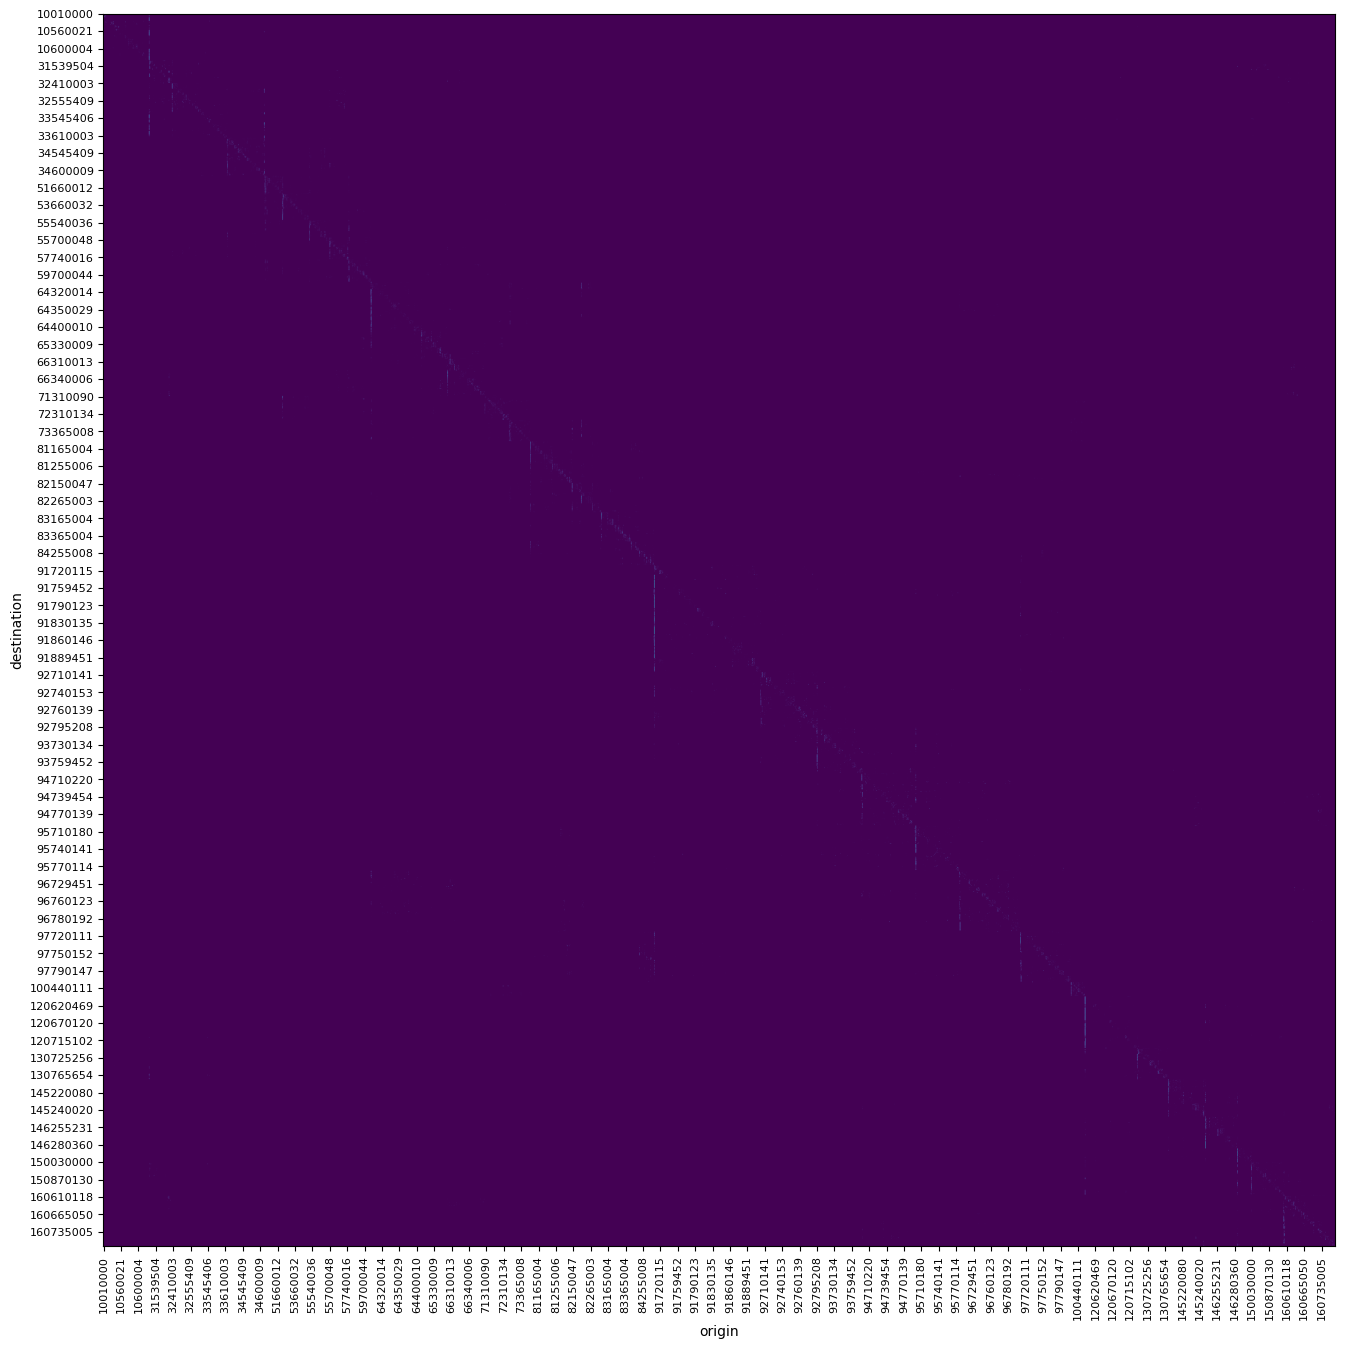

In [28]:
if manual:
    show = segments[-2]
    matrix = sm.probabilities.set_index(['segment', 'origin'], drop=True).drop(
        ['root', 'destination'], axis=1).sort_index(axis=1).loc[show].sort_index(axis=0)
    fig, ax = plt.subplots(figsize=(16,16))
    xlabels = list(matrix.index)
    ylabels = list(matrix.columns)
    label_step = int(len(sm.zones) / 70)
    ax.imshow(matrix.values)
    ax.set_xticks(range(0, len(xlabels), label_step), labels=xlabels[::label_step], fontsize=8, rotation=90)
    ax.set_yticks(range(0, len(ylabels), label_step), labels=ylabels[::label_step], fontsize=8)
    ax.set_xlabel('origin')
    ax.set_ylabel('destination')
    print('')

In [ ]:
# Free RAM
del sm.probabilities
del sm.utilities

## Trip generation

In [29]:
# Load trip generation
try:
    generation = pd.read_csv(model_path + 'generation_volumes.csv', index_col=0)
except FileNotFoundError:
    generation = pd.read_csv(model_path.replace(scenario, 'base') + 'generation_volumes.csv', index_col=0)

## Inner/inter-zonal choice

In [30]:
# Take inner-zonal probabilities from MiD2017 data by urbanisation degree
inner_probs = pd.read_csv(input_path + 'inner-zonal_probabilities_agg_urban.csv', index_col=0)
inner_probs

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
urbanisation,,,,,,,,,,,,
1,0.819107,0.723101,0.768868,0.660143,0.896435,0.867771,0.905745,0.817660,0.805125,0.730426,0.807273,0.813512
2,0.500000,0.399088,0.682540,0.449192,0.675676,0.616700,0.700272,0.648435,0.617801,0.553961,0.816667,0.635259
3,0.675926,0.474006,0.586957,0.502472,0.607143,0.672573,0.846899,0.703759,0.754777,0.604209,0.840000,0.700693


## Compute volumes (OD matrix)

$F_{ods} = GEN_{os} * p^{dest}_{ods} * (1 - p^{inner}_{os})$

Indecies:
* o: origin zone
* d: destination zone
* s: demand segment

In [48]:
{'route_type': 'destination'}.update({(seg, 'probability'): seg for seg in segments_optional})

In [50]:
prob_cols = [(seg, 'probability') for seg in segments_optional]
name_dict = {'route_type': 'destination'}
name_dict.update({seg: seg[0] for seg in prob_cols})
volumes = sm.los[['origin', 'route_type']+prob_cols].rename(columns=name_dict)
volumes.sample()

,origin,destination,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
71499,150850135,31590016,0.018072,0.000366,0.022113,0.001455,0.011369,0.000178


In [52]:
# Create inner-zonal probabilities
in_mask = volumes['origin']==volumes['destination']
zone_list = list(set(volumes['origin']))
if len(volumes.loc[in_mask]) == 0:
    volumes = pd.concat([volumes,
                         pd.DataFrame({'origin': zone_list,
                                       'destination': zone_list})
                        ]).reset_index()
    in_mask = volumes['origin']==volumes['destination']
urban_dict = sm.zones['urbanisation'].to_dict()
for seg in segments_optional:
    probs = inner_probs[seg]
    # Correct probabilities in volumes
    if len(probs) < len(zone_list): # aggregated probabilities by urbanisation degree
        volumes.loc[in_mask, seg] = volumes.loc[in_mask, 'origin'].map(urban_dict).map(probs)
        volumes.loc[~in_mask, seg] = volumes.loc[~in_mask, seg] * \
                                     volumes.loc[~in_mask, 'origin'].map(urban_dict).map(1 - probs)
    else:
        volumes.loc[in_mask, seg] = volumes.loc[in_mask, 'origin'].map(probs)
        volumes.loc[~in_mask, seg] = volumes.loc[~in_mask, seg] * \
                                     volumes.loc[~in_mask, 'origin'].map(1 - probs)

In [53]:
# calculate number of trips
for s in segments_optional:
    volumes[s] = volumes[s] * volumes['origin'].map(generation[s])

In [57]:
# check the sum (million trips per day)
seg_cols = [col for col in volumes.columns if col in segments]
print('Million trips per day: {}'.format(volumes[seg_cols].sum().sum() / 1e6 / 365))
print('Million inter-zonal trips per day: {}'.format(
    volumes.loc[volumes['origin']!=volumes['destination'], seg_cols].sum().sum() / 1e6 / 365))

Million trips per day: 141.12184818436046
Million inter-zonal trips per day: 43.36782421242277


## Policies

In [37]:
# Multi-purpose densified quarters in agglomeration areas around large cities
max_dist = params['trip_reduction_suburban_quarters']['max_dist_to_city']
if max_dist > 0:
    # Find quarters
    zones = gpd.GeoDataFrame(sm.zones, crs=sm.epsg).to_crs('EPSG:5234') # distance to meter
    cities = zones.loc[(zones['urbanisation']==1) & (zones['population']>200000)]
    centroids = gpd.GeoDataFrame(index=zones.loc[zones['urbanisation']==2].index,
                                 geometry=zones.loc[zones['urbanisation']==2, 'geometry'].centroid)
    quarters = gpd.sjoin_nearest(centroids, cities[['geometry']], max_distance=max_dist)
    # Reduce trips
    for seg in segments_optional:
        volumes.loc[volumes['origin'].isin(quarters.index), seg] *= \
            1 - params['trip_reduction_suburban_quarters'][seg]

## Save

In [56]:
# Save volumes table
sm.volumes = volumes.reset_index(drop=True)
sm.to_zippedpickles(model_path + 'de_volumes_choice', only_attributes=['volumes'])

volumes: 100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 19.61it/s]
